# Object detection model

> Object Detection Model


- skip_showdoc: true
- skip_exec: true

## COCO

### Data download

In [ ]:
import fiftyone as fo
import fiftyone.zoo as foz

#
# Only the required images will be downloaded (if necessary).
# By default, only detections are loaded
#

In [ ]:
dataset = foz.load_zoo_dataset(
    name="coco-2017",
    dataset_dir= "Data/coco",
    splits=["validation","train"],
    classes=["person", "car"],
    max_samples=50,
)

Found annotations at 'Data/coco/raw/instances_val2017.json'
Sufficient images already downloaded
Existing download of split 'validation' is sufficient
Found annotations at 'Data/coco/raw/instances_train2017.json'
Sufficient images already downloaded
Existing download of split 'train' is sufficient
Loading 'coco-2017' split 'validation'
 100% |███████████████████| 50/50 [292.8ms elapsed, 0s remaining, 172.0 samples/s]    
Loading 'coco-2017' split 'train'
 100% |███████████████████| 50/50 [245.2ms elapsed, 0s remaining, 205.8 samples/s]    
Dataset 'coco-2017-validation-train-50' created


In [ ]:
print(dataset.default_classes)

['0', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', '12', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', '26', 'backpack', 'umbrella', '29', '30', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', '45', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', '66', 'dining table', '68', '69', 'toilet', '71', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', '83', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [ ]:
# Visualize the dataset in the FiftyOne App
# session = fo.launch_app(dataset)

In [ ]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

# Create a histogram plot
output_notebook()

Loading BokehJS ...

### Dataset and DataLoaders

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import torchvision
from torchvision import models, datasets, tv_tensors, transforms
from torchvision.transforms import v2, ToPILImage
from torchvision.datasets import VisionDataset, CocoDetection
from torchinfo import summary
import torch.utils.data
from torch.utils.data import DataLoader

In [ ]:
from tqdm import tqdm
import cv2
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import math

In [ ]:
classes = ['0', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck',
           'boat', 'traffic light', 'fire hydrant', '12', 'stop sign', 'parking meter', 'bench',
           'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe',
           '26', 'backpack', 'umbrella', '29', '30', 'handbag', 'tie', 'suitcase', 'frisbee',
           'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
           'surfboard', 'tennis racket', 'bottle', '45', 'wine glass', 'cup', 'fork', 'knife', 'spoon',
           'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
           'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', '66', 'dining table', '68', '69',
           'toilet', '71', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
           'oven', 'toaster', 'sink', 'refrigerator', '83', 'book', 'clock', 'vase', 'scissors',
           'teddy bear', 'hair drier', 'toothbrush']

In [ ]:
classes[2]

'bicycle'

In [ ]:
train_path = './Data/coco/train'
val_path = './Data/coco/validation'

# Define transforms
# Define transforms for the dataset
transform2 = v2.Compose(
    [
        v2.ToImage(),
        # v2.Resize(size = desired_size),  # Resize image
        # v2.RandomPhotometricDistort(p=0.2),
        # v2.RandomZoomOut(fill={tv_tensors.Image: (123, 117, 104), "others": 0}),
        # # v2.RandomIoUCrop(),
        # v2.RandomHorizontalFlip(p=0.4),
        # # v2.SanitizeBoundingBoxes(),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

In [ ]:
# Load KITTI train dataset
train_dataset = CocoDetection(root=f'{train_path}/data',
                              annFile=f'{train_path}/labels.json', 
                              transform = transform2)

# Load KITTI test dataset
test_dataset = CocoDetection(root=f'{val_path}/data',
                            annFile=f'{val_path}/labels.json',
                            transform=transform2)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
sample = train_dataset[49]
img, target = sample
print(f"{type(img) = }\n{type(target) = }")

type(img) = <class 'torchvision.tv_tensors._image.Image'>
type(target) = <class 'list'>


In [ ]:
train_dataset2 = datasets.wrap_dataset_for_transforms_v2(train_dataset, target_keys=("boxes", "labels"))

test_dataset2 = datasets.wrap_dataset_for_transforms_v2(test_dataset, target_keys=("boxes", "labels"))

In [ ]:
len(train_dataset2), len(test_dataset2)

(50, 50)

In [ ]:
batch_size = 1

train_loader = DataLoader(train_dataset2,
                          batch_size=batch_size,
                          shuffle=True,
                          collate_fn=lambda batch: tuple(zip(*batch)),
                          num_workers = 8)

# Create DataLoader for test dataset
test_loader = DataLoader(test_dataset2,
                         batch_size=batch_size,
                         shuffle=True,
                         collate_fn=lambda batch: tuple(zip(*batch)),
                         num_workers = 8)

# Create DataLoader for test dataset
test_loader1 = DataLoader(test_dataset2,
                         batch_size=4,
                         shuffle=True,
                         collate_fn=lambda batch: tuple(zip(*batch)),
                         num_workers = 8)


In [ ]:
sample = train_dataset2[10]
img, target = sample
print(f"{type(img) = }\n{type(target) = }\n{target.keys() = }")
print(f"{type(target['boxes']) = }\n{type(target['labels']) = }")

type(img) = <class 'torchvision.tv_tensors._image.Image'>
type(target) = <class 'dict'>
target.keys() = dict_keys(['boxes', 'labels'])
type(target['boxes']) = <class 'torchvision.tv_tensors._bounding_boxes.BoundingBoxes'>
type(target['labels']) = <class 'torch.Tensor'>


In [ ]:
def cv2_show(image_np, label):
    image_cv2 = cv2.cvtColor((image_np * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
    if 'scores' in label:
        for bbox, item, score in zip(label['boxes'], label['labels'], label['scores']):
            if score > 0.2:
                cv2.rectangle(image_cv2,
                              (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])),
                              (0, 255, 0), 2)
            
                # Display the label
                font = cv2.FONT_HERSHEY_SIMPLEX
                cv2.putText(image_cv2, classes[item.item()],
                            (int(bbox[0]), int(bbox[1]) - 10),
                            font, 0.5, (0, 255, 0), 2, cv2.LINE_AA)
    else:
        for bbox, item in zip(label['boxes'], label['labels']):
            # Draw the bounding box
            cv2.rectangle(image_cv2,
                          (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])),
                          (0, 255, 0), 2)
        
            # Display the label
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(image_cv2, classes[item.item()],
                        (int(bbox[0]), int(bbox[1]) - 10),
                        font, 0.5, (0, 255, 0), 2, cv2.LINE_AA)

    # Convert the image back to RGB format for display with Matplotlib
    image_rgb = cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)
    
    return image_rgb


def show_single_image(image, label):
    # Convert the image tensor to a NumPy array
    image_np = image.numpy().transpose((1, 2, 0))
    image_rgb = cv2_show(image_np, label)
    # Display the image using Matplotlib
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()


def show_image(kitti_dataset):
    # Access an image and its label from the dataset
    image, label = kitti_dataset
    show_single_image(image, label)

# Define a function to display images
def show_images(images, labels, **kwargs):
    if len(images) == 1:
        show_single_image(images[0], labels[0])
    else:
        nrows = int(math.sqrt(len(images)))
        ncols = int(np.floor(len(images)/nrows))
            
        fig, axes = plt.subplots(nrows, ncols, **kwargs)
        # Adjust the spacing between subplots
        plt.subplots_adjust(wspace=0.01, hspace=0.01)
    
        # Display the image using Matplotlib
        for ax, image, label in zip(axes.flat, images, labels):
            # Convert image to numpy array and adjust pixel values
            image_np = np.asarray(image).transpose((1, 2, 0))
            image_rgb = cv2_show(image_np, label)
            
            # Display image
            ax.imshow(image_rgb)
            ax.axis('off')
    
        for ax in axes.flat[len(images):]:
            ax.axis('off')
        plt.show()

In [ ]:
images, label = train_dataset2[18]
len(images.squeeze(0).shape)

3

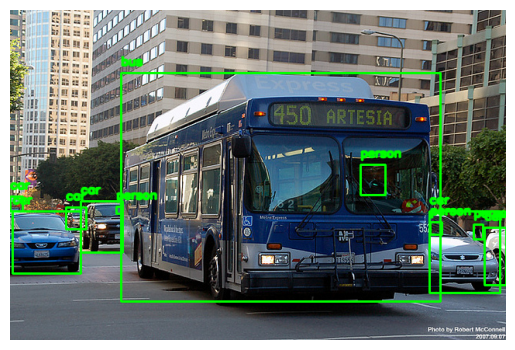

In [ ]:
show_image(train_dataset2[18])

#### Iter

In [ ]:
# Get a batch of images and labels from the data loader
examples = iter(train_loader)
images, labels = next(examples)


In [ ]:
images[0].shape

torch.Size([3, 388, 500])

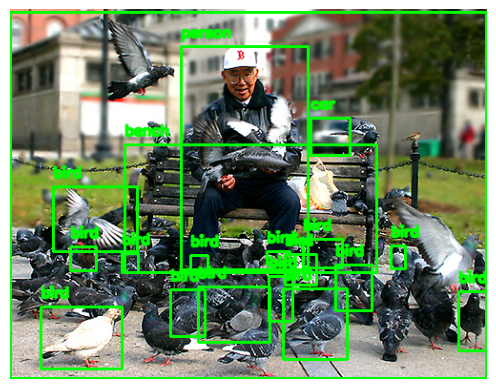

In [ ]:
show_images(images, labels, figsize=(15, 5))

### Model

In [ ]:
import torch 
from torchvision.io.image import read_image
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

In [ ]:
import torchvision.models as models
from torchvision.models import ResNet18_Weights
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.transform import GeneralizedRCNNTransform


In [ ]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:

# random_input = np.random.rand(1, 3, 100, 100)
# # Load the ResNet-18 backbone
# backbone = resnet_fpn_backbone(backbone_name='resnet18', weights=ResNet18_Weights.IMAGENET1K_V1)
# summary(backbone, input_size=random_input.shape, verbose = 0, depth  = 5, col_names = (
#                 "input_size",
#                 "output_size",
#                 "num_params",
#                 "params_percent",
#                 "kernel_size",
#                 "mult_adds",
#                 "trainable",
#             ))

In [ ]:
# backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# # ``FasterRCNN`` needs to know the number of
# # output channels in a backbone. For mobilenet_v2, it's 1280
# # so we need to add it here
# backbone.out_channels = 1280
# summary(backbone, input_size=random_input.shape, verbose = 0, depth  = 5, col_names = (
#                 "input_size",
#                 "output_size",
#                 "num_params",
#                 "params_percent",
#                 "kernel_size",
#                 "mult_adds",
#                 "trainable",
#             ))

In [ ]:
# # Define the resize parameters
# min_size = (300,)  # Change this to your desired minimum size
# max_size = 500    # Change this to your desired maximum size
# # Create the Faster R-CNN model with the modified transform
# model = FasterRCNN(backbone = backbone, num_classes=80)
# model.transform.min_size = min_size
# model.transform.max_size = max_size
# model = model.to(device)

In [ ]:
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
preprocess = weights.transforms()
model = fasterrcnn_resnet50_fpn_v2(weights=weights, box_score_thresh=0.9)
model = model.to(device)

In [ ]:
def start_tensorboard(file_name):
    ######################## TENSORBOARD ########################
    import sys
    from torch.utils.tensorboard import SummaryWriter
    from datetime import datetime
    # default `log_dir` is "runs" - we'll be more specific here
    formatted_time =  datetime.now().strftime("%H:%M:%S")
    
    writer = SummaryWriter(log_dir = f'{file_name} {formatted_time}')
    print(f'{file_name} {formatted_time}')
    
    writer.add_text('learning_rate', f'{learning_rate}')
    writer.add_text('epochs', f'{epochs}')
    writer.add_text('batch_size', f'{batch_size}')
    
    
    # writer.add_graph(model, images)
    writer.flush()
    ###################################################
    return writer

In [ ]:
# Define an optimizer (you can use any optimizer from torch.optim)
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(),
                            lr=learning_rate,
                            momentum=0.7)
# Define optimizer and learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

epochs = 5


In [ ]:
def val_model(current_epoch, n_total_steps):
    # Evaluation loop
    model.train()
    total_loss = 0.0
    
    with torch.no_grad():
        for imgs, targets in tqdm(test_loader):
            # Move input data to GPU
            imgs = [img.to(device) for img in imgs]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # Forward pass
            loss_dict = model(imgs, targets)
            losses = sum(loss for loss in loss_dict.values())
            
            total_loss += losses.item()
    ############## TENSORBOARD ########################
    writer.add_scalar('val loss', total_loss / len(test_loader), current_epoch * n_total_steps)
    writer.flush()
    # print(f'[step:{epoch * n_total_steps + i}/ {epochs * n_total_steps} ] loss: {running_loss / 100}')
    
    running_loss = 0.0
    ###################################################
    # Print average loss for the evaluation
    print(f"Evaluation Loss : {total_loss / len(test_loader):.4f}")

In [ ]:
# Training loop
running_loss = 0.0
n_total_steps = len(train_loader)

writer = start_tensorboard(f'coco/mobilenetv2 {epochs} {batch_size} {learning_rate}')

for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    
    for i, (imgs, targets) in enumerate(tqdm(train_loader)):
        # Move input data to GPU
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Forward pass
        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass and optimization
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        total_loss += losses.item()
        running_loss += losses.item()

        if (i+1) % 5 == 0:
            ############## TENSORBOARD ########################
            writer.add_scalar('training loss', running_loss / 5, epoch * n_total_steps + i)
            writer.flush()
            # print(f'[step:{epoch * n_total_steps + i}/ {epochs * n_total_steps} ] loss: {running_loss / 100}')
            
            running_loss = 0.0
            ###################################################
    # Update learning rate scheduler
    lr_scheduler.step()
    val_model(epoch, n_total_steps)
    # Print average loss for the epoch
    print(f"Average Loss: {total_loss / len(train_loader):.4f}")

coco/mobilenetv2 5 1 0.001 02:34:10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.36it/s]


Evaluation Loss : 0.9402
Average Loss: 0.9971


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  6.14it/s]


Evaluation Loss : 0.9366
Average Loss: 0.6584


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.29it/s]


Evaluation Loss : 0.9596
Average Loss: 0.5211


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.29it/s]


Evaluation Loss : 0.9549
Average Loss: 0.4428


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:08<00:00,  6.09it/s]

Evaluation Loss : 0.9715
Average Loss: 0.4278


In [ ]:
model.eval()
# Get a batch of images and labels from the data loader
examples = iter(test_loader1)

In [ ]:
images, labels = next(examples)
imgs = [img.to(device) for img in images]

targets = [{k: v.to(device) for k, v in t.items()} for t in labels]

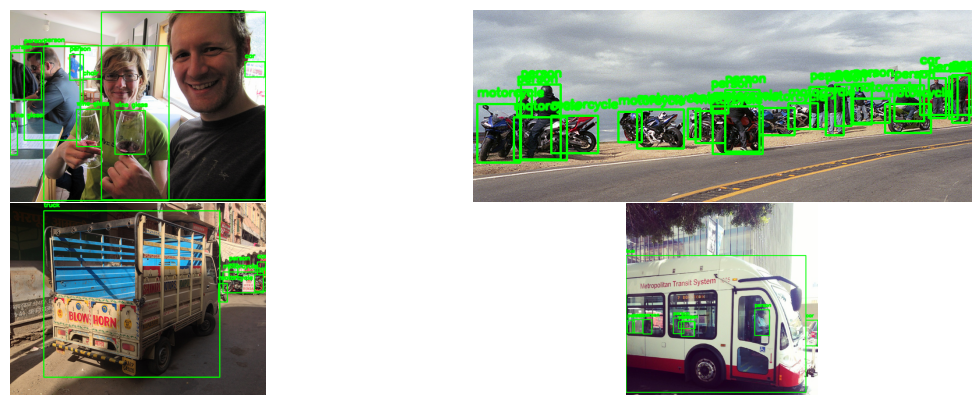

In [ ]:
show_images(images, labels, figsize=(15, 5))

In [ ]:
loss_dict = model(imgs)

In [ ]:
loss_dict = [{k: v.to('cpu') for k, v in t.items()} for t in loss_dict] 

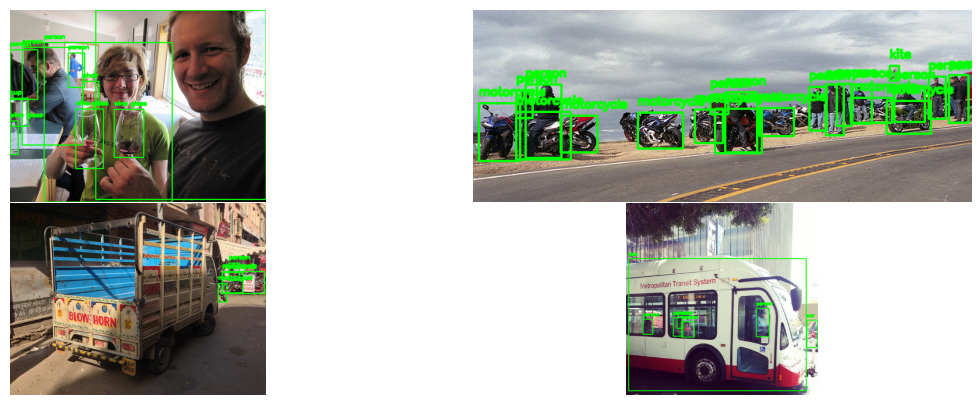

In [ ]:
show_images(images, loss_dict, figsize=(15, 5))

In [ ]:
############## TENSORBOARD ########################
writer.close()
###################################################